In [2]:
TRAIN_PATH = "CovidDataset1/Train"
VAL_PATH = "CovidDataset1/Val"
TEST_PATH = "CovidDataset1/test"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image

In [4]:
from keras.metrics import *

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
]

In [5]:

def create_model():

    # add preprocessing layer to the front of VGG
    vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

    # don't train existing weights
    for layer in vgg.layers:
      layer.trainable = False
    
      # useful for getting number of classes
    #folders = glob('CovidDataset/Train/*')
    # our layers - you can add more if you want
    x = Flatten()(vgg.output)
    x = Dense(220, activation='relu')(x)
    x = Dropout(0.2)(x)


    prediction = Dense(1, activation='sigmoid')(x)


    # create a model object
    model = Model(inputs=vgg.input, outputs=prediction)

    model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=METRICS)
    return model


In [6]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
# Train from scratch
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)

test_dataset = image.ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')

Found 8764 images belonging to 2 classes.


In [9]:
validation_generator = test_dataset.flow_from_directory(
    VAL_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')

Found 2150 images belonging to 2 classes.


In [10]:
test_generator = test_dataset.flow_from_directory(
  TEST_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')

Found 800 images belonging to 2 classes.


In [11]:
train_generator.class_indices

{'Covid': 0, 'Negative': 1}

In [12]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping, CSVLogger
checkpoint_path = "vgg16/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='loss', verbose=1,save_weights_only=True,save_best_only=True, mode='auto')
early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)
log_csv = CSVLogger('vgg16/vgg16.csv', separator=',', append=False)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5)

callbacks_list = [checkpoint, early_stop,reduce_lr, log_csv]


In [12]:
from keras.callbacks import ModelCheckpoint

hist = model.fit(
    train_generator,
   steps_per_epoch=len(train_generator),
    epochs = 45,
    validation_data = validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks_list
)

Epoch 1/45
274/274 [==============================] - 114s 389ms/step - loss: 0.4007 - tp: 4464.0000 - fp: 692.0000 - tn: 2989.0000 -  : 619.0000 - accuracy: 0.8504 - precision: 0.8658 - recall: 0.8782 - val_loss: 0.2154 - val_tp: 1732.0000 - val_fp: 166.0000 - val_tn: 248.0000 - val_ : 4.0000 - val_accuracy: 0.9209 - val_precision: 0.9125 - val_recall: 0.9977

Epoch 00001: loss improved from inf to 0.40072, saving model to vgg16\cp-0001.ckpt
Epoch 2/45
274/274 [==============================] - 97s 352ms/step - loss: 0.2739 - tp: 4617.0000 - fp: 511.0000 - tn: 3170.0000 -  : 466.0000 - accuracy: 0.8885 - precision: 0.9004 - recall: 0.9083 - val_loss: 0.1369 - val_tp: 1699.0000 - val_fp: 65.0000 - val_tn: 349.0000 - val_ : 37.0000 - val_accuracy: 0.9526 - val_precision: 0.9632 - val_recall: 0.9787

Epoch 00002: loss improved from 0.40072 to 0.27392, saving model to vgg16\cp-0002.ckpt
Epoch 3/45
274/274 [==============================] - 96s 352ms/step - loss: 0.2428 - tp: 4665.0000 - f


Epoch 00019: loss did not improve from 0.13659
Epoch 20/45
274/274 [==============================] - 97s 353ms/step - loss: 0.1332 - tp: 4857.0000 - fp: 214.0000 - tn: 3467.0000 -  : 226.0000 - accuracy: 0.9498 - precision: 0.9578 - recall: 0.9555 - val_loss: 0.0975 - val_tp: 1719.0000 - val_fp: 62.0000 - val_tn: 352.0000 - val_ : 17.0000 - val_accuracy: 0.9633 - val_precision: 0.9652 - val_recall: 0.9902

Epoch 00020: loss improved from 0.13659 to 0.13319, saving model to vgg16\cp-0020.ckpt
Epoch 21/45
274/274 [==============================] - 97s 353ms/step - loss: 0.1230 - tp: 4865.0000 - fp: 189.0000 - tn: 3492.0000 -  : 218.0000 - accuracy: 0.9536 - precision: 0.9626 - recall: 0.9571 - val_loss: 0.1104 - val_tp: 1719.0000 - val_fp: 65.0000 - val_tn: 349.0000 - val_ : 17.0000 - val_accuracy: 0.9619 - val_precision: 0.9636 - val_recall: 0.9902

Epoch 00021: loss improved from 0.13319 to 0.12298, saving model to vgg16\cp-0021.ckpt
Epoch 22/45
274/274 [=============================

274/274 [==============================] - 97s 354ms/step - loss: 0.1124 - tp: 4888.0000 - fp: 165.0000 - tn: 3516.0000 -  : 195.0000 - accuracy: 0.9589 - precision: 0.9673 - recall: 0.9616 - val_loss: 0.0907 - val_tp: 1726.0000 - val_fp: 45.0000 - val_tn: 369.0000 - val_ : 10.0000 - val_accuracy: 0.9744 - val_precision: 0.9746 - val_recall: 0.9942

Epoch 00039: loss did not improve from 0.09864
Epoch 40/45
274/274 [==============================] - 97s 354ms/step - loss: 0.0970 - tp: 4894.0000 - fp: 147.0000 - tn: 3534.0000 -  : 189.0000 - accuracy: 0.9617 - precision: 0.9708 - recall: 0.9628 - val_loss: 0.0808 - val_tp: 1719.0000 - val_fp: 34.0000 - val_tn: 380.0000 - val_ : 17.0000 - val_accuracy: 0.9763 - val_precision: 0.9806 - val_recall: 0.9902

Epoch 00040: loss improved from 0.09864 to 0.09703, saving model to vgg16\cp-0040.ckpt
Epoch 41/45
274/274 [==============================] - 97s 354ms/step - loss: 0.1077 - tp: 4887.0000 - fp: 153.0000 - tn: 3528.0000 -  : 196.0000 - ac

In [13]:
os.listdir(checkpoint_dir)

['checkpoint',
 'cp-0001.ckpt.data-00000-of-00001',
 'cp-0001.ckpt.index',
 'cp-0002.ckpt.data-00000-of-00001',
 'cp-0002.ckpt.index',
 'cp-0003.ckpt.data-00000-of-00001',
 'cp-0003.ckpt.index',
 'cp-0004.ckpt.data-00000-of-00001',
 'cp-0004.ckpt.index',
 'cp-0005.ckpt.data-00000-of-00001',
 'cp-0005.ckpt.index',
 'cp-0006.ckpt.data-00000-of-00001',
 'cp-0006.ckpt.index',
 'cp-0007.ckpt.data-00000-of-00001',
 'cp-0007.ckpt.index',
 'cp-0008.ckpt.data-00000-of-00001',
 'cp-0008.ckpt.index',
 'cp-0010.ckpt.data-00000-of-00001',
 'cp-0010.ckpt.index',
 'cp-0012.ckpt.data-00000-of-00001',
 'cp-0012.ckpt.index',
 'cp-0013.ckpt.data-00000-of-00001',
 'cp-0013.ckpt.index',
 'cp-0014.ckpt.data-00000-of-00001',
 'cp-0014.ckpt.index',
 'cp-0015.ckpt.data-00000-of-00001',
 'cp-0015.ckpt.index',
 'cp-0020.ckpt.data-00000-of-00001',
 'cp-0020.ckpt.index',
 'cp-0021.ckpt.data-00000-of-00001',
 'cp-0021.ckpt.index',
 'cp-0024.ckpt.data-00000-of-00001',
 'cp-0024.ckpt.index',
 'cp-0025.ckpt.data-00000

In [14]:
import tensorflow as tf
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'vgg16\\cp-0045.ckpt'

In [15]:
# Create a basic model instance
model = create_model()

# Evaluate the model
results = model.evaluate_generator(validation_generator, 1)
print("The model has a {}% accuracy, with a loss of {}.".format(results[5]*100, results[0])) 


C:\Users\User\anaconda3\envs\TF-Gpu\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


The model has a 28.125% accuracy, with a loss of 0.9737836122512817.


In [16]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

results = model.evaluate_generator(validation_generator, 1)
print("The model has a {}% accuracy, with a loss of {}.".format(results[5]*100, results[0])) 


The model has a 64.0625% accuracy, with a loss of 0.02494862675666809.


In [17]:
model.evaluate_generator(train_generator)

[0.08536786586046219,
 5040.0,
 247.0,
 3434.0,
 43.0,
 0.9669100642204285,
 0.9532816410064697,
 0.9915404319763184]

In [19]:
model.evaluate_generator(validation_generator)

[0.14889313280582428,
 1734.0,
 82.0,
 332.0,
 2.0,
 0.9609302282333374,
 0.9548457860946655,
 0.9988479018211365]

In [20]:
model.evaluate_generator(test_generator)

[0.3773021996021271,
 400.0,
 80.0,
 320.0,
 0.0,
 0.8999999761581421,
 0.8333333134651184,
 1.0]

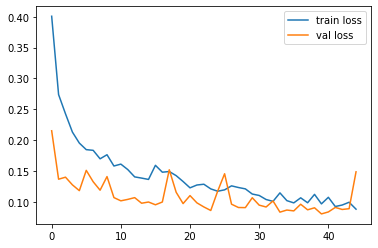

<Figure size 432x288 with 0 Axes>

In [20]:
# loss
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

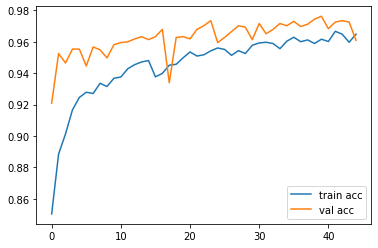

<Figure size 432x288 with 0 Axes>

In [21]:
# accuracies
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

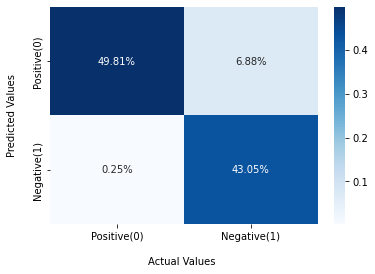

In [22]:
cm=[[398, 55],
     [ 2, 344]]

import seaborn as sns

ax = sns.heatmap(cm/np.sum(cm), cmap = "Blues", fmt='.2%', annot=True)

ax.set_ylabel('Predicted Values\n')
ax.set_xlabel('\nActual Values ');

## Ticket labels - List must be in alphabetical order
ax.yaxis.set_ticklabels(['Positive(0)','Negative(1)'])
ax.xaxis.set_ticklabels(['Positive(0)','Negative(1)'])

## Display the visualization of the Confusion Matrix.
plt.show()

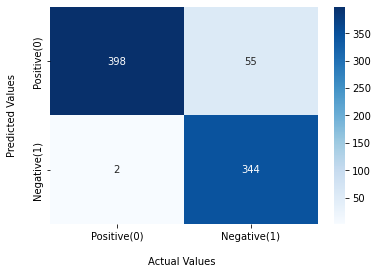

In [23]:
cm=[[398, 55],
     [ 2, 344]]

import seaborn as sns

ax = sns.heatmap(cm, cmap = "Blues", annot=True, fmt=".0f")

ax.set_ylabel('Predicted Values\n')
ax.set_xlabel('\nActual Values ');

## Ticket labels - List must be in alphabetical order
ax.yaxis.set_ticklabels(['Positive(0)','Negative(1)'])
ax.xaxis.set_ticklabels(['Positive(0)','Negative(1)'])

## Display the visualization of the Confusion Matrix.
plt.show()